In [45]:
library(rhdf5)
library(MASS)
# library(BoutrosLab.plotting.general)
library(ggplot2)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:latticeExtra’:

    layer




# Test reading h5 and accessing data

In [38]:
fh <- "/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/sim.h5"

Get internal structure of h5 file

In [39]:
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_GROUP,,
2,/counts,continuous,H5I_DATASET,INTEGER,13000 x 50000
3,/counts,discrete,H5I_DATASET,INTEGER,13000 x 50000
4,/,guides,H5I_GROUP,,
5,/guides,est_efficiency_D10,H5I_DATASET,FLOAT,4000
6,/guides,est_efficiency_D100,H5I_DATASET,FLOAT,4000
7,/guides,metadata,H5I_DATASET,COMPOUND,4000
8,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 4000


# Plot row sums of discrete vs. continuous $X_1$ matrix

In [42]:
x1.dis.rowsums <- rowSums(h5read(file = fh, name = "x/x1_discrete"))
x1.cont.rowsums <- rowSums(h5read(file = fh, name = "x/x1_continuous"))

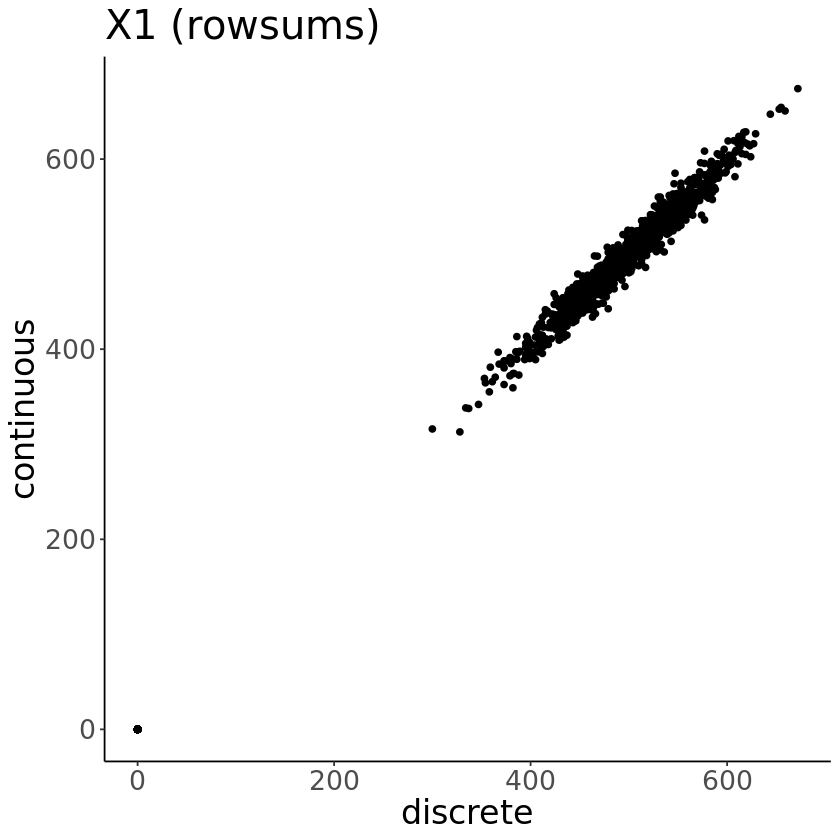

In [52]:
x1.rowsums.df <- data.frame(discrete = x1.dis.rowsums, continuous = x1.cont.rowsums)

x1.scatter <- ggplot(x1.rowsums.df, aes(x = discrete, y = continuous)) + geom_point() + 
                theme_classic() + theme(text = element_text(size = 20)) + ggtitle("X1 (rowsums)")

x1.scatter

In [57]:
tiff("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/x1_scatterplot.tiff",
    res = 300, units = "in", height = 6, width = 6)
print(x1.scatter)
dev.off()

png 
  2

# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [58]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
percent.mito <- h5read(fh, "x/percent_mito")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")

In [59]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,10227,0.7143842,-5.687418
2,4570,0.4467681,-2.191908
3,8934,0.7701684,-5.064239
4,6939,0.5659939,-6.208954
5,3110,0.5480017,-1.092979
6,8946,0.6334062,-2.452710


# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene (targeting) with `glm.nb` (MASS library)

In [88]:
test.gene <- sample(guides.metadata$target.gene, 1)

print(test.gene)

obs.counts <- h5read(file = fh, name = "counts/discrete", index = list(test.gene, 1:50000))
gene.data.continuous.x <- data.frame(guide.eff = as.numeric(h5read(file = fh, name = "x/x1_continuous", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                        percent.mito = percent.mito,
                       scaling.factor = scaling.factors)

gene.data.discrete.x <- data.frame(guide.eff = as.numeric(h5read(file = fh, name = "x/x1_discrete", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                        percent.mito = percent.mito,
                       scaling.factor = scaling.factors)

[1] 190


In [89]:
head(gene.data.continuous.x)

,guide.eff,s.score,g2m.score,counts,percent.mito,scaling.factor
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,0,0.17229155,-0.15874222,1,0.03069795,0.050107
2,0,-0.11410318,0.20041946,0,0.06200627,0.050082
3,0,-0.05495927,0.03672557,3,0.05384273,0.050384
4,0,-0.07455024,0.27507092,3,0.04150387,0.049990
5,0,0.11608382,-0.21085589,0,0.05731243,0.049868
6,0,0.27953127,-0.17125363,0,0.03168604,0.049912


Model counts simulated from **discrete** $X_1$ using **continuous** $X_1$ values.

In [93]:
ml.cont <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),
             data = gene.data.continuous.x)

In [94]:
summary(ml.cont)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data.continuous.x, 
    init.theta = 1.492697896, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5567  -1.1981  -0.3046   0.3798   4.1021  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.19686    0.01128  283.31   <2e-16 ***
guide.eff    -1.41022    0.08808  -16.01   <2e-16 ***
s.score       2.57699    0.04849   53.15   <2e-16 ***
g2m.score     2.42986    0.02566   94.70   <2e-16 ***
percent.mito  3.82139    0.24799   15.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.4927) family taken to be 1)

    Null deviance: 66215  on 49999  degrees of freedom
Residual deviance: 52692  on 49995  degrees of freedom
AIC: 163138

Number of Fisher Scoring iterations: 1


              Theta:  1.4927 
          Std. Err.:

In [92]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
190,3.173881,-2.023426,2.548098,2.458895,4.109315


Model counts simulated from **discrete** $X_1$ using **discrete** $X_1$ values.

In [95]:
ml.disc <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),
             data = gene.data.discrete.x)

summary(ml.disc)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data.discrete.x, 
    init.theta = 1.505104804, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5636  -1.1989  -0.3069   0.3798   4.1147  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.19581    0.01126  283.80   <2e-16 ***
guide.eff    -2.05663    0.10910  -18.85   <2e-16 ***
s.score       2.58020    0.04842   53.28   <2e-16 ***
g2m.score     2.43086    0.02562   94.90   <2e-16 ***
percent.mito  3.83786    0.24760   15.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5051) family taken to be 1)

    Null deviance: 66440  on 49999  degrees of freedom
Residual deviance: 52603  on 49995  degrees of freedom
AIC: 162885

Number of Fisher Scoring iterations: 1


              Theta:  1.5051 
          Std. Err.:  

# Test for all target genes

E.g. the 1000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [28]:
ml.list <- list()

for (gene in guides.metadata$target.gene[1:3]) {
    print(gene)
    obs.counts <- h5read(file = fh, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factors = scaling.factors)
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score, data = gene.data)
    ml.list[[gene]] <- ml
}

[1] 3683
[1] 1175
[1] 11331


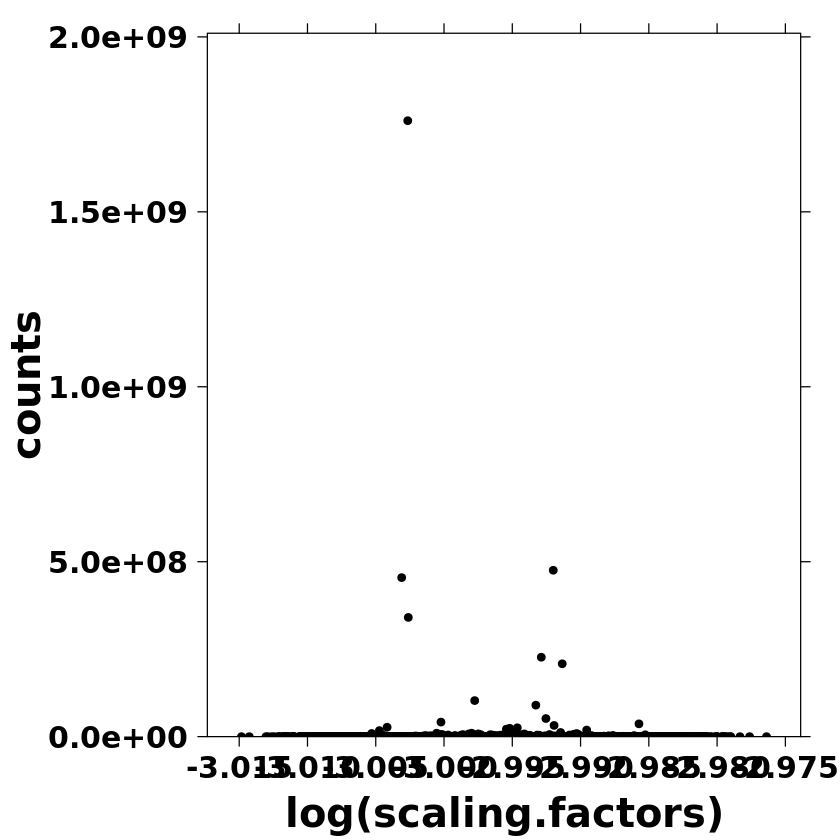

In [29]:
create.scatterplot(
    formula = counts ~ log(scaling.factors),
    data = gene.data
)

In [32]:
cor.test(log(gene.data$scaling.factors), gene.data$counts, method = 'spearman')

Warning message in cor.test.default(log(gene.data$scaling.factors), gene.data$counts, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  log(gene.data$scaling.factors) and gene.data$counts
S = 2.0774e+13, p-value = 0.525
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.002842585 


In [14]:
summary(ml.list[[1175]])


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factors)), 
    data = gene.data, init.theta = 1.517836905, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7483  -0.7233  -0.3835  -0.0663   4.2255  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.82181    0.01076 169.385  < 2e-16 ***
guide.eff   -5.19567    0.71304  -7.287 3.18e-13 ***
s.score      3.05735    0.01492 204.953  < 2e-16 ***
g2m.score    2.33210    0.01370 170.213  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5178) family taken to be 1)

    Null deviance: 131409  on 49999  degrees of freedom
Residual deviance:  34801  on 49996  degrees of freedom
AIC: 99823

Number of Fisher Scoring iterations: 1


              Theta:  1.5178 
          Std. Err.:  0.0280 

 2 x log-likelihood:  -99813.2890 

In [15]:
coeffs[1175,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1175,1.766874,-4.83825,3.061181,2.336816,1.22111
